## Keras - Text Classification

#### IMDB Dataset

**Goal**: classify movie reviews as *positive* or *negative* using the review comments. 

The [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. There is an equal number of positive and negative reviews.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.11.0


In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 3s 0us/step


In [3]:
# The text of reviews have been converted into integers, 
# where each integer represents a specific word in a dictionary.
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
# Movie reviews may have different lengths
len(train_data[0]), len(train_data[1])

(218, 189)

#### Preprocessing

As human reader, it will be better if we first convert integers back to text.

In [10]:
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [11]:
decode_review(train_data[0]b)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

We pad the arrays to make them the same length, then create an integer tensor of shape `max_length * num_reviews`. 

`keras.preprocessing.sequence.pad_sequences`
- Pad sequences to the same length.
- `value`: the value being added.
- `padding`: `pre` or `post`.
- `maxlen`: the maximum length after this padding preprocess.

In [16]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [19]:
keras.layers.GlobalAveragePooling1D?

#### Build the model

`keras.layers.Embedding(input_dim, output_dim)`
- Turns positive integers (indexes) into dense vectors of fixed size.
- This layer can only be used as the first layer in a model.

`keras.layers.GlobalAveragePooling1D()`
- It is common to periodically insert a Pooling layer in-between successive Convolutional layers in a ConvNet architecture. 
- Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
- The Pooling Layer operates independently on every depth slice of the input and resizes it spatially, using the MAX operation. 

In [20]:
vocab_size = 10000

model = keras.Sequential()

# The layer takes the integer-coded vocabulary and looks up the embedding vector for each word-index. 
# These vectors are learned as the model trains. Resulting dimension: `(batch, sequence, embedding)`.
model.add(keras.layers.Embedding(vocab_size, 16))

# This layer returns a fixed-length output vector for each example by averaging over the sequence dimension.
# This allows the model to handle input of variable length in a simple way.
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))

# Sigmoid function for binary classification
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


#### Compile the model

In general, `binary_crossentropy` is better for dealing with probabilities -- it measures the "distance" between probability distrubtions, or in our case, between the ground-truth distribution and the predictions.

In [21]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
# Cross validation

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### Train the model

In [23]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40, # 40 iterations
                    batch_size=512, # mini-batches of 512 samples
                    validation_data=(x_val, y_val), # used to evaluate the loss or any model metrics at the end of each epoch
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 77us/step - loss: 0.6918 - acc: 0.5714 - val_loss: 0.6896 - val_acc: 0.6572
Epoch 2/40
15000/15000 [==============================] - 1s 57us/step - loss: 0.6852 - acc: 0.7403 - val_loss: 0.6806 - val_acc: 0.7370
Epoch 3/40
15000/15000 [==============================] - 1s 56us/step - loss: 0.6722 - acc: 0.7679 - val_loss: 0.6645 - val_acc: 0.7532
Epoch 4/40
15000/15000 [==============================] - 1s 58us/step - loss: 0.6496 - acc: 0.7657 - val_loss: 0.6394 - val_acc: 0.7767
Epoch 5/40
15000/15000 [==============================] - 1s 67us/step - loss: 0.6168 - acc: 0.7986 - val_loss: 0.6044 - val_acc: 0.7877
Epoch 6/40
15000/15000 [==============================] - 1s 55us/step - loss: 0.5756 - acc: 0.8140 - val_loss: 0.5646 - val_acc: 0.7990
Epoch 7/40
15000/15000 [==============================] - 1s 59us/step - loss: 0.5298 - acc: 0.8331 - val_loss: 0.5225 - val_acc

#### A graph of accuracy and loss over time

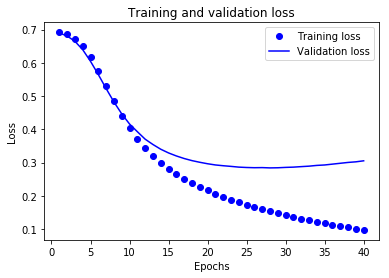

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # bo => blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b=> blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

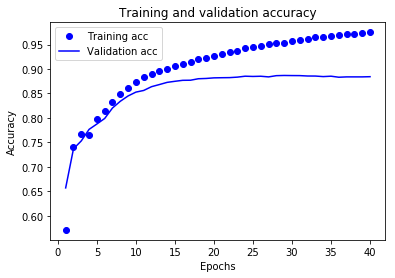

In [29]:
acc_values = history.history['acc']
val_acc_values = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

From the graphs, we see that the validation loss and accuracy start to move in the undesired direction, which indicates possible overfitting. We could prevent overfitting by stopping training after about 20 epochs.